In [1]:
from acevedo_clss_and_fcns import * 
device = 'cpu'
if torch.cuda.is_available():
    torch.cuda.init()
    if torch.cuda.is_initialized():
        device = 'cuda:0'
#device = torch.device(device)
print(f"{device = }")
from torch_geometric.nn import GNNExplainer
import numpy as np

/DeepenData/.miniconda/envs/geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = 'cuda:0'


### Masked flux- / flux+ 


In [2]:
def get_explanations(model, loader):
    
    explainer    = GNNExplainer(model, epochs=1000, num_hops = None, lr=0.01).to(device, non_blocking=True)
    model.to(device, non_blocking=True)


    model.eval()
    gc.collect()
    torch.cuda.empty_cache() 
    edge_num           = loader.dataset[0].edge_index.shape[1]
    all_graphs_weights = []#torch.empty(edge_num,1).to(device)

    for graph in loader.dataset[0:1000]:
        _, edge_weights =  explainer.explain_graph(graph.x.to(device, non_blocking=True), graph.edge_index.to(device, non_blocking=True))
        
        all_graphs_weights.append(edge_weights.reshape(edge_num,1))
        
        
        

    return pd.DataFrame(
                        torch.stack(all_graphs_weights,1).squeeze().cpu().numpy().astype(float))
    
                                

MASKED_GCN_Concentration                = torch.load("./results/trained_models/Masked/GCN/Concentration/Model_GCN_10-12-2022_15h_12min_best_ValAcc_0.9311302415995557_epoch_30.pt")
MASKED_loader_only_Concen               = torch.load("./results/dataloaders/MASKED_loader_only_Concen.pt").get_test_loader()
Explanations_MASKED_GCN_Concentration   = get_explanations(MASKED_GCN_Concentration, MASKED_loader_only_Concen)

MASKED_GCN_Fluxes              = torch.load("./results/trained_models/Masked/GCN/Fluxes/Model_GCN_10-12-2022_15h_04min_best_ValAcc_0.995279089141905_epoch_0.pt")
MASKED_loader_only_Fluxes      = torch.load("./results/dataloaders/MASKED_loader_only_Fluxes.pt").get_test_loader()
Explanations_MASKED_GCN_Fluxes = get_explanations(MASKED_GCN_Fluxes, MASKED_loader_only_Fluxes)


MASKED_GCN_Concen_plus_Fluxes                = torch.load("./results/trained_models/Masked/GCN/Concen_plus_Fluxes/Model_GCN_10-12-2022_15h_13min_best_ValAcc_0.995279089141905_epoch_0.pt")
MASKED_loader_Concen_plus_Fluxes             = torch.load("./results/dataloaders/MASKED_loader_Concen_plus_Fluxes.pt").get_test_loader()
Explanations_MASKED_GCN_Concen_plus_Fluxes   = get_explanations(MASKED_GCN_Concen_plus_Fluxes, MASKED_loader_Concen_plus_Fluxes)                               


Explain graph: 100%|██████████| 1000/1000 [00:01<00:00, 581.42it/s]


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

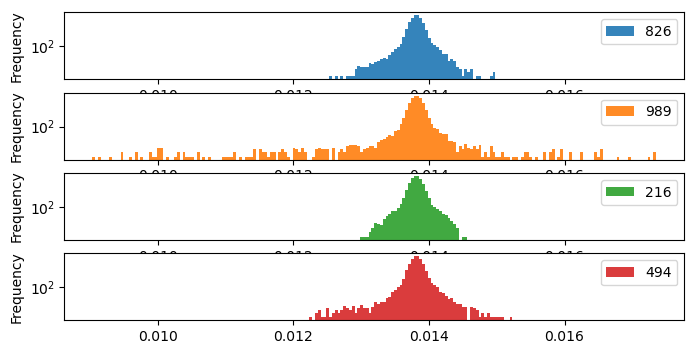

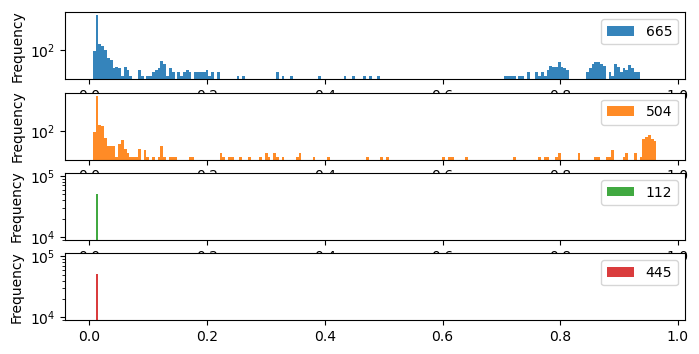

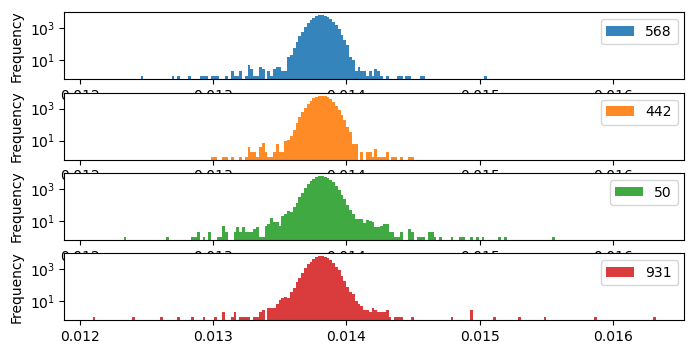

In [8]:
def plot_explanation_sample(explanations):
    return explanations.loc[:,np.random.randint(0, explanations.columns.__len__(), 4 )].select_dtypes(float).plot.hist(bins=200, alpha=0.9, figsize=(8,4), subplots=True, sharey=False, 
                      sharex=False, logy = True, grid=False)


plot_explanation_sample(Explanations_MASKED_GCN_Fluxes)
plot_explanation_sample(Explanations_MASKED_GCN_Concentration)
plot_explanation_sample(Explanations_MASKED_GCN_Concen_plus_Fluxes)

In [11]:
def get_df_labels_and_colnames(all_graphs_weights_df, loader, path_to_save_labels, path_PYG_graph, path_NX_graph):
    
    train_labels = []
    for graph in tqdm.tqdm(loader.dataset[0:1000]):
        train_labels.append(graph.y.cpu().item())
    assert train_labels.__len__() == all_graphs_weights_df.shape[1]
    #all_graphs_weights.shape

    labels =  ["PKU" if l == 0 else "Control" for l in train_labels] 
    
    pd.Series(labels).to_csv(path_to_save_labels)

    all_graphs_weights_df.columns = [str(col) for col in all_graphs_weights_df.columns]
    print(f"{all_graphs_weights_df.shape=}")
    
    
    
    edge_mask = abs(all_graphs_weights_df.sum(axis=1)) >=  0 #np.percentile(all_graphs_weights_df.sum(axis=1), 99)


    filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]  
    filtered_graph_weights    = filtered_graph_weights_df.transpose() 
    filtered_graph_weights["Label"] = list(labels)
    filtered_graph_weights.reset_index(drop=True, inplace=True)
    filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
       

    PYG_graph = torch.load(path_PYG_graph)
    NX_graph  = nx.read_gpickle(path_NX_graph)
    edge_0_node_idxs =  PYG_graph.edge_index[0,:]
    edge_1_node_idxs =  PYG_graph.edge_index[1,:]
    edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
    edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
    edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
    edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]
    

    return edges_node_names_explainer_subgraphs
 
# plot_explanation_sample(Explanations_MASKED_GCN_Fluxes)
# plot_explanation_sample(Explanations_MASKED_GCN_Concentration)
# plot_explanation_sample(Explanations_MASKED_GCN_Concen_plus_Fluxes)



explanatory_subgraph_MASKED_GCN_Fluxes = get_df_labels_and_colnames(Explanations_MASKED_GCN_Fluxes, MASKED_loader_only_Fluxes, 
                                                                  path_to_save_labels = "./results/dataframes/labels_masked_only_Fluxes.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_only_Fluxes.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_recon_graph.gpickle")

explanatory_subgraph_MASKED_GCN_Concentration = get_df_labels_and_colnames(Explanations_MASKED_GCN_Concentration, MASKED_loader_only_Concen, 
                                                                  path_to_save_labels = "./results/dataframes/labels_masked_only_Concen.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_only_Concen.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_recon_graph.gpickle")

explanatory_subgraph_MASKED_GCN_Concen_plus_Fluxes = get_df_labels_and_colnames(Explanations_MASKED_GCN_Concen_plus_Fluxes, MASKED_loader_Concen_plus_Fluxes, 
                                                                  path_to_save_labels = "./results/dataframes/labels_masked_Concen_plus_Fluxes.csv",
                                                                  path_PYG_graph      = "./results/graphs/PYG_graph_Concen_plus_Fluxes.pt" , 
                                                                  path_NX_graph       = "./results/graphs/NX_recon_graph.gpickle")

100%|██████████| 1000/1000 [00:00<00:00, 597564.33it/s]


all_graphs_weights_df.shape=(50442, 1000)


100%|██████████| 1000/1000 [00:00<00:00, 665762.54it/s]


all_graphs_weights_df.shape=(50442, 1000)


100%|██████████| 1000/1000 [00:00<00:00, 549208.33it/s]


all_graphs_weights_df.shape=(50442, 1000)


In [13]:
explanatory_subgraph_MASKED_GCN_Fluxes.to_parquet(
    "./results/dataframes/explanatory_subgraph_MASKED_GCN_Fluxes.parquet.gzip", compression='gzip')
explanatory_subgraph_MASKED_GCN_Concentration.to_parquet(
    "./results/dataframes/explanatory_subgraph_MASKED_GCN_Concentration.parquet.gzip", compression='gzip')
explanatory_subgraph_MASKED_GCN_Concen_plus_Fluxes.to_parquet(
    "./results/dataframes/explanatory_subgraph_MASKED_GCN_Concen_plus_Fluxes.parquet.gzip", compression='gzip')


### Find clusters

In [72]:
#edge_mask = all_graphs_weights_df.sum(axis=1) > np.percentile(all_graphs_weights_df.sum(axis=1), 99)
#filtered_graph_weights_df = all_graphs_weights_df.loc[  edge_mask, :]

#filtered_graph_weights_df.sum(axis=1).plot.hist(logy = True, bins=300)
#filtered_graph_weights_df.shape, edge_mask.shape



weights = abs(explanatory_subgraph_MASKED_GCN_Fluxes.select_dtypes(float)).sum(axis=1)
cutoff  = np.percentile(weights, 90)


highest_weights = weights[weights > cutoff]

len(highest_weights), min(highest_weights),max(highest_weights),'|||||', len(weights),  min(weights), max(weights)


highest_explanatory_subgraph = explanatory_subgraph_MASKED_GCN_Fluxes[weights > cutoff].select_dtypes(float).reset_index(drop=True)

highest_weights

15       13.841219
16       13.891234
18       13.831987
25       13.921249
29       13.825515
           ...    
50392    13.848322
50404    13.838364
50428    13.820537
50435    13.820541
50436    13.821612
Length: 5045, dtype: float64

In [69]:
#filtered_graph_weights_df.sum(axis=0).plot.hist(logy = True, bins=500)
import umap
import seaborn as sns

reducer = umap.UMAP(n_epochs=500, repulsion_strength=.1, min_dist=0.001, learning_rate=0.01, n_neighbors=10, spread=20,n_jobs=-1, metric='cosine')

embedding = reducer.fit_transform(highest_explanatory_subgraph)




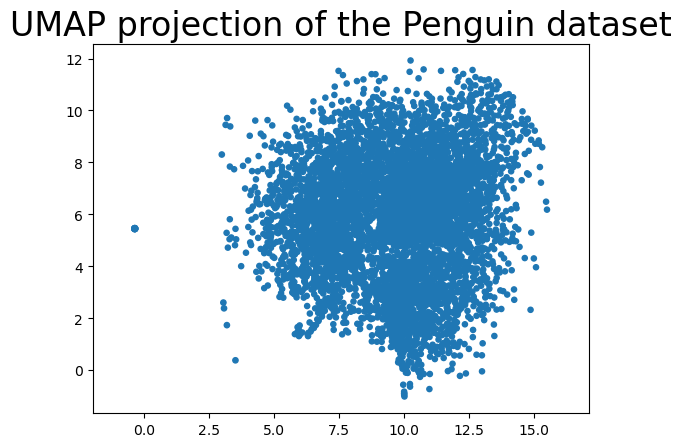

In [71]:

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], s = highest_weights,
    #c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);

filtered_graph_weights = filtered_graph_weights_df.transpose() 
filtered_graph_weights["Label"] = list(labels)

filtered_graph_weights.reset_index(drop=True, inplace=True)
filtered_graph_weights.columns = [str(col) for col in filtered_graph_weights.columns]
filtered_graph_weights

PYG_graph = torch.load("./results/graphs/PYG_graph_Concen_plus_Fluxes.pt")
NX_graph  = nx.read_gpickle("./results/graphs/NX_graph_Concen_plus_Fluxes.gpickle")
edge_0_node_idxs =  PYG_graph.edge_index[0,:]
edge_1_node_idxs =  PYG_graph.edge_index[1,:]
edge_0_nodes     = [list(NX_graph.nodes)[i] for i in  edge_0_node_idxs]
edge_1_nodes     = [list(NX_graph.nodes)[i] for i in  edge_1_node_idxs]
edges_df = pd.DataFrame({'node1': edge_0_nodes, 'node2':edge_1_nodes})
edges_node_names_explainer_subgraphs = pd.concat([edges_df, all_graphs_weights_df], axis=1).loc[edge_mask,:]

edges_node_names_explainer_subgraphs


edges_node_names_explainer_subgraphs.to_parquet(
    "./results/dataframes/Masked_edges_node_names_explainer_subgraphs.parquet.gzip", compression='gzip')